In [1]:
# Импорт библиотек и модулей
from pyballistics import ozvb_termo, get_powder_names, get_full_options, get_db_powder
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from tqdm import tqdm

In [2]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
winter_r = cm.get_cmap('Blues', 256)
newcolors = winter_r(np.linspace(0, 1, 256))
newcolors[:50, :] = cm.get_cmap('BuPu_r', 50)(np.linspace(0.0, 1, 50))
newcmp = ListedColormap(newcolors)

In [3]:
# настройка шрифтов
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [4]:
# Список порохов БД:
db = get_powder_names()

# Функции:

In [5]:
# функция расчёта ОЗВБ для одной точки пороха марки powder_name при соблюдении всех ограничений одновременно
def func_solve(ωq, Δ, powder_name):
    
    # исходные данные:
    d = 76.2e-3
    q = 7.1
    v_pm = 690
    n_S = 1.04
    p_0 = 30e6
    p_ign = 5e6
    φ1 = 1.02
    g = 9.80665
    dt = 1e-6
    S = n_S * np.pi * ((d**2) / 4)

    # общие ограничения:
    p_m_max = 360e6
    l_m_max = 65 * d

    # индивидуальные ограничения:
    v_pm_50_min = 610
    g_p_50_max = 14000 * g
    
    # расчёт:
    flag_wave = True
    Label = False
    ω = ωq * q
    W_0 = ω / Δ
    initial_data = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 293.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'windage': {'shock_wave': flag_wave},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'v_p': 690, 'x_p': l_m_max, 'p_max': p_m_max}}
    result = ozvb_termo(initial_data)
    if result['stop_reason'] == 'v_p':
        l = result['x_p'][-1]
        W = result['W_p'][-1]
        # Проверка ограничения при -50:
        initial_data_50 = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 223.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'windage': {'shock_wave': flag_wave},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'x_p': l, 'p_max': p_m_max}}
        result_50 = ozvb_termo(initial_data_50)
        if (result_50['v_p'][-1] >= v_pm_50_min):
            # Проверка ограничения при +50:
            initial_data50 = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 323.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'windage': {'shock_wave': flag_wave},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'x_p': l, 'p_max': p_m_max}}
            result50 = ozvb_termo(initial_data50)
            if (result50['stop_reason'] == 'x_p'):
                delta = get_db_powder(powder_name)['delta']
                f_ign = get_db_powder('ДРП')['f']
                b_ign = get_db_powder('ДРП')['b']
                ω_ign = (p_ign  / f_ign) * (W_0 - (ω / delta)) * (1 / (1 + b_ign * p_ign / f_ign))
                φ = φ1 + (ω_ign + ω) / (3*q)
                # пересчёт давления атмосферы
                if flag_wave == True:
                    k_air = 1.4
                    p0a = 1e5
                    c_0a = 340
                    ind_m = np.argmax(result50['p_m'])
                    v_p = result50['v_p'][ind_m]
                    mach = c_0a / v_p
                    mach_ = (k_air+1)*v_p/4/c_0a 
                    p0a *= 1 + k_air*(k_air+1)/4*(mach*mach) + k_air*mach*np.sqrt(1+mach_*mach_) 
                else:
                    p0a = 1e5
                gx_max = S * (np.max(result50['p_m']) - p0a) / (φ * q)
                if (gx_max <= g_p_50_max):
                    Label = True
    else:
        l = l_m_max
        W = W_0 + S*l
    solve = {'Label': Label, 'W': W}  
    return solve

In [ ]:
#функуия инициилизирования файлов с названиями марок порохов для записи в них результатов:
def file_creation(powder):
    mass_name = []
    for i in range(len(powder)):
        letter = list(powder[i])
        file_name = ''
        for j in range(len(letter)):
            if letter[j] == '/':
                letter[j] = '_'
            file_name += letter[j]
        file_name += '.csv'
        DF = pd.DataFrame(columns=['x1', 'x2', 'Label', 'W'])
        DF.to_csv(file_name, sep=';', index=False, encoding='cp1251')
        mass_name.append(file_name)
    return mass_name

In [ ]:
def db_names(powder):
    mass_name = []
    for i in range(len(powder)):
        letter = list(powder[i])
        file_name = ''
        for j in range(len(letter)):
            if letter[j] == '/':
                letter[j] = '_'
            file_name += letter[j]
        file_name += '.csv'
        mass_name.append(file_name)
    return mass_name    

In [ ]:
def save_result_point(ωq, Δ, powder_name, file_name):
    try:
        solve = func_solve(ωq, Δ, powder_name)
        df1 = pd.read_csv(file_name, sep=';', encoding='cp1251')
        dict_solve = {'x1':[ωq], 'x2':[Δ], 'Label':[solve['Label']], 'W':[solve['W']]}
        df2 = pd.DataFrame(dict_solve)
        data_new = pd.concat([df1, df2])
        data_new.to_csv(file_name, sep=';', index=False, encoding='cp1251')
        return solve
    except Exception as solve:
        print(f'Ошибка в точке x1 = {ωq}, x2 = {Δ}')
        return -1

In [ ]:
# Функция чтения и записи результатов прямых задач одного пороха в массивы
def open_file(file_name):
    df = pd.read_csv(file_name, sep=';', encoding='cp1251')
    mass_ωq = np.array(df['x1'])
    mass_Δ = np.array(df['x2'])
    mass_label = np.array(df['Label'])
    mass_W = np.array(df['W'])
    return [mass_ωq, mass_Δ, mass_label, mass_W]

# Случайный перебор всех порошков для определения МДБР:

In [ ]:
ωq_min = 0.1
ωq_max = 1
Δ_min = 100
Δ_max = 1000

In [ ]:
# # Раскомментируй ТОЛЬКОa ДЛЯ ПЕРВОГО ЗАПУСКА ПРОГРАММЫ, потому что у тебя нет файлов, в которые я (прога) записую результаты
# # Инициилизируем пустые файлы для записи результатов
# data_name = file_creation(db)

In [ ]:
# Инициилизируем названия файлов для записи результатов
data_name = db_names(db)

In [ ]:
n1 = 1000 # количество рандомных точек в искомой плоскости для определения допустимых БР каждого пороха
n2 = 5000 # количество рандомных точек во втором приближении в каждом порохе
n3 = 1000 # количество рандомных точек во третьем приближении в каждом порохе
C = 31 # точность 3-ого приближения(количество точек вправо и влево от минимальной точки) с шагом заданной точности 
C1 = 11

In [ ]:
for i in tqdm(range(len(db))):
    for j in range(n1):
        ωq = np.random.uniform(ωq_min, ωq_max)
        Δ = np.random.uniform(Δ_min, Δ_max)
        save_result_point(ωq, Δ, db[i], data_name[i])
    open_data = open_file(data_name[i])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    mass_ωq_f = []
    mass_Δ_f = []
    mass_W_f = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            mass_ωq_f.append(mass_ωq[m])
            mass_Δ_f.append(mass_Δ[m])
            mass_W_f.append(mass_W[m])
    plt.figure(dpi=100)
    plt.scatter(mass_ωq_t, mass_Δ_t,color='r',s=3)
    plt.scatter(mass_ωq_f, mass_Δ_f,color='k',s=3)
    plt.title(f'Порох "{db[i]}"')
    plt.xlabel('$ω/q$')
    plt.ylabel('$Δ$, кг/м^3')
    plt.xlim(0.1,1)
    plt.ylim(100,1000)
    plt.grid()
    plt.show()

In [ ]:
file_empty = 'Пороха с пустым МДБР.csv'
df_empty = pd.DataFrame(columns=['powder_name'])
df_empty.to_csv(file_empty, sep=';', index=False, encoding='cp1251')

In [ ]:
# поиск порохов, где нет вообще решений
# формируем массив db_new порохов с непустым МДБР:
# формируем массив db_new_name названий файлов этих порошков:
db_new = []
for i in tqdm(range(len(db))): 
    open_data = open_file(data_name[i])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    for m in range(len(mass_ωq)):
        if (mass_solve[m] == True):
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            continue
    if (len(mass_ωq_t) == 0):
        df1 = pd.read_csv(file_empty, sep=';', encoding='cp1251')
        dict_solve = {'powder_name': [data_name[i][0:-4]]}
        df2 = pd.DataFrame(dict_solve)
        data_new = pd.concat([df1, df2])
        data_new.to_csv(file_empty, index=False, encoding='cp1251')
    else:
        db_new.append(db[i])
db_new_name = db_names(db_new)

In [ ]:
file_empty = 'Пороха с пустым МДБР.csv'
df_empty = pd.read_csv(file_empty, sep=';', encoding='cp1251')
powder_empty = np.array(df_empty['powder_name'])
print(f'Пороха с пустым МДБР:\n {powder_empty}')
len(db_new), len(db_new_name), len(powder_empty)

In [ ]:
# Строим диаграммы всех отобранных порохов для определения границ для более точного поиска
for p in range(len(db_new)):
    open_data = open_file(db_new_name[p])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    mass_ωq_f = []
    mass_Δ_f = []
    mass_W_f = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            mass_ωq_f.append(mass_ωq[m])
            mass_Δ_f.append(mass_Δ[m])
            mass_W_f.append(mass_W[m])
    plt.figure(dpi=100)
    plt.scatter(mass_ωq_f, mass_Δ_f,color='r',s=3)
    plt.title(f'Порох "{db_new[p]}"')
    plt.xlabel('$ω/q$')
    plt.ylabel('$Δ$, кг/м^3')
    cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=mass_W_t, cmap=newcmp, s=3)
    plt.colorbar(cb).set_label(f'W')
    index_min = np.argmin(mass_W_t)
    min_ωq = mass_ωq_t[index_min]
    min_Δ = mass_Δ_t[index_min]
    min_W = func_solve(min_ωq, min_Δ, db_new[p])['W']
    plt.scatter(min_ωq, min_Δ, color='k',s=50, marker='*')
    plt.xlim(0.1,1)
    plt.ylim(100,1000)
    plt.grid()
    plt.show()

In [ ]:
# Делаем розыгрыш точек в более узкой области (в области МДБР)
for p in tqdm(range(len(db_new))):
    open_data = open_file(db_new_name[p])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            continue
    ωq_min = 0.8 * np.min(mass_ωq_t)
    ωq_max = 1.2 * np.max(mass_ωq_t)
    Δ_min = 0.8 * np.min(mass_Δ_t)
    Δ_max = 1.2 * np.max(mass_Δ_t)
    for k in range(n2):
        ωq = np.random.uniform(ωq_min, ωq_max)
        Δ = np.random.uniform(Δ_min, Δ_max)
        save_result_point(ωq, Δ, db_new[p], db_new_name[p])  
    open_data = open_file(db_new_name[p])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    mass_ωq_f = []
    mass_Δ_f = []
    mass_W_f = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            mass_ωq_f.append(mass_ωq[m])
            mass_Δ_f.append(mass_Δ[m])
            mass_W_f.append(mass_W[m])
    plt.figure(dpi=100)
    plt.scatter(mass_ωq_f, mass_Δ_f,color='r',s=3)
    plt.title(f'Порох "{db_new[p]}"')
    plt.xlabel('$ω/q$')
    plt.ylabel('$Δ$, кг/м^3')
    cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=mass_W_t, cmap=newcmp, s=3)
    plt.colorbar(cb).set_label(f'W')
    index_min = np.argmin(mass_W_t)
    min_ωq = mass_ωq_t[index_min]
    min_Δ = mass_Δ_t[index_min]
    min_W = func_solve(min_ωq, min_Δ, db_new[p])['W']
    plt.scatter(min_ωq, min_Δ, color='k',s=50, marker='*')
    plt.xlim(0.1,1)
    plt.ylim(100,1000)
    plt.grid()
    plt.show()
    print(min_ωq, min_Δ, min_W)
    func_solve(min_ωq, min_Δ, db_new[p])

In [ ]:
# Делаем розыгрыш точек в еще более узкой области(в области максимума)
for p in tqdm(range(len(db_new))):
    open_data = open_file(db_new_name[p])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            continue
    index_min = np.argmin(mass_W_t)
    min_ωq = mass_ωq_t[index_min]
    min_Δ = mass_Δ_t[index_min]
    ωq_min = 0.8 * min_ωq
    ωq_max = 1.2 * min_ωq
    Δ_min = 0.8 * min_Δ
    Δ_max = 1.2 * min_Δ
    for k in range(n3):
        ωq = np.random.uniform(ωq_min, ωq_max)
        Δ = np.random.uniform(Δ_min, Δ_max)
        save_result_point(ωq, Δ, db_new[p], db_new_name[p])       
    open_data = open_file(db_new_name[p])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    mass_ωq_f = []
    mass_Δ_f = []
    mass_W_f = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            mass_ωq_f.append(mass_ωq[m])
            mass_Δ_f.append(mass_Δ[m])
            mass_W_f.append(mass_W[m])          
    mass_ωq_posl = mass_ωq[len(mass_ωq)-n3:]
    mass_Δ_posl = mass_Δ[len(mass_ωq)-n3:]
    plt.figure(dpi=100)
    plt.scatter(mass_ωq_f, mass_Δ_f,color='r',s=1)
    plt.title(f'Марка пороха "{db_new[p]}"')
    plt.xlabel('$ω/q$')
    plt.ylabel('$Δ$, кг/м^3')
    cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=mass_W_t, cmap='winter', s=3)
    plt.colorbar(cb).set_label(f'W')
    index_min = np.argmin(mass_W_t)
    min_ωq = mass_ωq_t[index_min]
    min_Δ = mass_Δ_t[index_min]
    min_W = func_solve(min_ωq, min_Δ, db_new[p])['W']
    plt.scatter(mass_ωq_posl, mass_Δ_posl, color='y',s=1)
    plt.scatter(min_ωq, min_Δ, color='g',s=50, marker='*',zorder=1)
    plt.xlim(0.1,1)
    plt.ylim(100,1000)
    plt.grid()
    plt.show()
    print(f'Wp_min = {min_W} м3')

In [ ]:
# вывожу массив mass_min для просмотра какое минимальное значение критерия Wp выдаёт каждый порох
mass_min_W = []
mass_min_ωq = []
mass_min_Δ = []
for i in tqdm(range(len(db_new))):
    open_data = open_file(db_new_name[i])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            continue
    ind_min = np.argmin(mass_W_t)
    mass_min_W.append(min(mass_W_t))
    mass_min_ωq.append(mass_ωq_t[ind_min])
    mass_min_Δ.append(mass_Δ_t[ind_min])
mass_min_W

# Поиск оптимального решения среди всех отобранных порошков:

In [ ]:
# Нажимать ТОЛЬКО ОДИН РАЗ, чтобы создать пустой файл Оптмимальное решение.csv
file_end = 'Оптимальное_решение.csv'
df_end = pd.DataFrame(columns=['x1', 'x2', 'W', 'powder_name'])
df_end.to_csv(file_end, sep=';', index=False, encoding='cp1251')

In [ ]:
# Проводим сближение по двум сеткам
for i in tqdm(range(len(db_new))):
    open_data = open_file(db_new_name[i])
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == True:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
        else:
            continue
            
    if len(mass_ωq_t)>0 and (min(mass_W_t)<=0.016):
        flag = False
        index_min = np.argmin(mass_W_t)
        min_ωq = mass_ωq_t[index_min]
        min_Δ = mass_Δ_t[index_min]
        min_W = func_solve(min_ωq, min_Δ, db_new[i])['W']
        
        
        while flag == False:
            mass_ωq_setka = np.linspace(min_ωq-0.002*(C-1)/2, min_ωq +0.002*(C-1)/2, C)
            mass_Δ_setka = np.linspace(min_Δ-1*(C-1)/2, min_Δ+1*(C-1)/2, C)
            flag1 = False
            check = []
            W = []
            massiv_ωq = []
            massiv_Δ = []
            for k in range(len(mass_ωq_setka)):
                for z in range(len(mass_Δ_setka)):
                    result = func_solve(mass_ωq_setka[k], mass_Δ_setka[z], db_new[i])
                    check.append(result['Label'])
                    W.append(result['W'])
                    massiv_ωq.append(mass_ωq_setka[k])
                    massiv_Δ.append(mass_Δ_setka[z])
            for n in range(len(check)):
                if (check[n] == True) and (W[n] < min_W):
                    min_W = W[n]
                    min_ωq = massiv_ωq[n]
                    min_Δ = massiv_Δ[n]
                    flag1 = True
            if flag1 == False:
                flag = True
        
        
        flag_correct = False
        while flag_correct == False:
            mass_ωq_setka = np.linspace(min_ωq-0.001*(C1-1)/2, min_ωq +0.001*(C1-1)/2, C1)
            mass_Δ_setka = np.linspace(min_Δ-0.5*(C1-1)/2, min_Δ+0.5*(C1-1)/2, C1)
            flag1_correct = False
            check = []
            W = []
            massiv_ωq = []
            massiv_Δ = []
            for k in range(len(mass_ωq_setka)):
                for z in range(len(mass_Δ_setka)):
                    result = func_solve(mass_ωq_setka[k], mass_Δ_setka[z], db_new[i])
                    check.append(result['Label'])
                    W.append(result['W'])
                    massiv_ωq.append(mass_ωq_setka[k])
                    massiv_Δ.append(mass_Δ_setka[z])
            for n in range(len(check)):
                if (check[n] == True) and (W[n] < min_W):
                    min_W = W[n]
                    min_ωq = massiv_ωq[n]
                    min_Δ = massiv_Δ[n]
                    flag1_correct = True
            if flag1_correct == False:
                flag_correct = True
        
        
        df1 = pd.read_csv(file_end, sep=';', encoding='cp1251')
        dict_solve = {'x1':[min_ωq], 'x2':[min_Δ], 'W':[min_W], 'powder_name':[db_new_name[i][0:-4]]}
        df2 = pd.DataFrame(dict_solve)
        data_new = pd.concat([df1, df2])
        data_new.to_csv(file_end, sep=';', index=False, encoding='cp1251')
        plt.figure(dpi=100)
        plt.title(f'Порох "{db_new[i]}"')
        plt.xlabel('$ω/q$')
        plt.ylabel('$Δ$, кг/м$^3$')
        cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=mass_W_t, cmap='bwr', s=3)
        plt.colorbar(cb).set_label(f'W')
        plt.scatter(min_ωq, min_Δ, color='r',s=50, marker='*')
        plt.xlim(0.1,1)
        plt.ylim(100,1000)
        plt.grid()
        plt.show()
        print(func_solve(min_ωq,min_Δ,db_new[i]))

# Результаты расчёта:

In [ ]:
file_end = 'Оптимальное_решение.csv'
df_optimum = pd.read_csv(file_end, sep=';', encoding='cp1251') 
best_ωq = np.array(df_optimum['x1'])
best_Δ = np.array(df_optimum['x2'])
best_W = np.array(df_optimum['W'])
best_powder = np.array(df_optimum['powder_name'])
best_dictionary = {'ω/q': best_ωq,
                   'Δ': best_Δ,
                   'W' : best_W,
                   'Порох': best_powder}
best_dictionary

In [ ]:
mass_best_ωq = []
mass_best_Δ = []
mass_best_W = []
mass_best_powder = []
ind_best = 0
for i in range(len(db_new)):
    if mass_min_W[i] < 0.016:
        mass_best_ωq.append(best_ωq[ind_best])
        mass_best_Δ.append(best_Δ[ind_best])
        mass_best_W.append(best_W[ind_best])
        letter = list(best_dictionary['Порох'][ind_best])
        name_opt = ''
        for j in range(len(letter)):
            if letter[j] == '_':
                letter[j] = '/'
            name_opt += letter[j]
        mass_best_powder.append(name_opt)
        ind_best+=1
    else:
        mass_best_ωq.append(mass_min_ωq[i])
        mass_best_Δ.append(mass_min_Δ[i])
        mass_best_W.append(mass_min_W[i])
        mass_best_powder.append(db_new[i])

In [ ]:
index_min = np.argmin(mass_best_W)
name_opt = mass_best_powder[index_min]
file_opt = ''
letter = list(mass_best_powder[index_min])
for j in range(len(letter)):
    if letter[j] == '/':
        letter[j] = '_'
    file_opt += letter[j]
file_opt += '.csv'
d = 76.2e-3
S = 1.04 * np.pi * d**2 / 4
db_opt = name_opt
ωq_opt = mass_best_ωq[index_min]
Δ_opt = mass_best_Δ[index_min]
W_opt = mass_best_W[index_min]
ω_opt = ωq_opt * 7.1
W_0_opt = ω_opt / Δ_opt
lm = (mass_best_W[index_min] - W_0_opt)/S
print(f'Оптимальные условия заряжания: \n Порох {db_opt},\n ω/q = {ωq_opt},\n Δ = {Δ_opt} кг/м3,\n W = {W_opt} м3')
print(f' Масса пороха ω = {ω_opt} кг \n Объём каморы W0 = {W_0_opt} м3\n Длина ведущей части ствола l = {lm} м')

In [ ]:
func_solve(ωq_opt, Δ_opt, db_opt)

In [ ]:
I = []
for i in range(len(db_new)):
    flag = 0
    for j in range(len(powder_empty)):
        if (db_new[i] == powder_empty[j]):
            flag += 1
    if flag == 0:
        I.append(get_db_powder(db[i])['I_e'])

In [ ]:
best3_solve_ind = []
best3_solve_W = []
best3_solve_ωq = []
best3_solve_Δ = []
best3_solve_powder = []

In [ ]:
for i in range(3):
    index = np.argmin(best_W)
    best3_solve_ind.append(index)
    best3_solve_W.append(np.min(best_W))
    best3_solve_ωq.append(best_ωq[index])
    best3_solve_Δ.append(best_Δ[index])
    best3_solve_powder.append(best_powder[index]) 
    best_ωq = np.delete(best_ωq,index)
    best_Δ = np.delete(best_Δ,index)
    best_W = np.delete(best_W,index)
    best_powder = np.delete(best_powder,index)

In [ ]:
best3_solve_powder, best3_solve_W, best3_solve_ωq, best3_solve_Δ

In [ ]:
ind = [0,0,0]
ind[0] = mass_best_W.index(best3_solve_W[0])
ind[1] = mass_best_W.index(best3_solve_W[1])
ind[2] = mass_best_W.index(best3_solve_W[2])

# ГРАФИКА РАСПРЕДЕЛЕНИЯ РЕЗУЛЬТАТОВ:

In [ ]:
%config InlineBackend.figure_format = 'svg' #векторный формат #векторный формат

In [ ]:
%matplotlib inline

In [ ]:
mass_best_Wgr = [i * 1e3 for i in mass_best_W]
plt.figure(dpi=150,figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.scatter(I, mass_best_W, s=20, color='steelblue', alpha=0.6, edgecolor='black')
plt.plot(I, mass_best_W, linestyle = ':')
plt.scatter(I[ind[0]], mass_best_W[ind[0]],s=100,color='gold',marker='*',edgecolor='black',label='Лучшее решение 16/1 тр')
plt.scatter(I[ind[1]], mass_best_W[ind[1]],s=100,color='grey',marker='*',edgecolor='black',label='Второе решение 18/1 тр')
plt.scatter(I[ind[2]], mass_best_W[ind[2]],s=100,color='orange',marker='*',edgecolor='black',label='Третье решение 14/7')
plt.ylabel('$W^{}_{pm}$, м$^{3}$', fontsize=12)
plt.legend (loc='upper left',fontsize=12)
plt.grid()


plt.subplot(2, 1, 2)
plt.scatter(I, mass_best_Wgr, s=60, color='steelblue', alpha=0.6, edgecolor='black')
plt.plot(I, mass_best_Wgr, linestyle =':')
plt.scatter(I[ind[0]], mass_best_Wgr[ind[0]],s=200,color='gold',marker='*',edgecolor='black',label='Лучшее решение 16/1 тр')
plt.scatter(I[ind[1]], mass_best_Wgr[ind[1]],s=200,color='grey',marker='*',edgecolor='black',label='Второе решение 18/1 тр')
plt.scatter(I[ind[2]], mass_best_Wgr[ind[2]],s=200,color='orange',marker='*',edgecolor='black',label='Третье решение 14/7')
plt.xlabel(r'$I^{}_{e}$, Па с',fontsize=12)
plt.ylabel('$W^{}_{pm}$, дм$^{3}$', fontsize=12)
plt.axis([I[index_min]-0.3*1e6,I[index_min]+0.3*1e6,mass_best_Wgr[index_min]-0.1,mass_best_Wgr[index_min]+2])
plt.grid()

plt.savefig('3 лучших порошка на плоскости (САБПЛОТ).png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
grad = []
for i in range(len(mass_best_W)):
    grad.append(mass_best_W[i])
plt.figure(dpi=150)
plt.scatter(mass_best_ωq,mass_best_Δ,s=10,c=grad,cmap=newcmp)
plt.xlabel('ω/q', fontsize=12)
plt.ylabel(r'$Δ$, кг/м$^{3}$',fontsize=12)
plt.colorbar(label = r'$W^{}_{pm}$, м$^{3}$')
plt.scatter(mass_best_ωq[ind[0]], mass_best_Δ[ind[0]],s=100,color='gold',edgecolor='black',marker='*',label='Лучшее решение 16/1 тр')
plt.scatter(mass_best_ωq[ind[1]], mass_best_Δ[ind[1]],s=100,color='grey',edgecolor='black',marker='*',label='Второе решение 18/1 тр')
plt.scatter(mass_best_ωq[ind[2]], mass_best_Δ[ind[2]],s=100,color='orange',edgecolor='black',marker='*',label='Третье решение 14/7')
plt.legend (loc=7, fontsize=12)
plt.grid()
plt.savefig('3 лучших порошка на плоскости2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for p in range(len(best3_solve_powder)):
    letter = list(best3_solve_powder[p])
    db_name = ''
    for j in range(len(letter)):
        if letter[j] == '_':
            letter[j] = '/'
        db_name += letter[j]
    fn = '.csv'
    file_name = best3_solve_powder[p] + fn
    open_data = open_file(file_name)
    mass_ωq = open_data[0]
    mass_Δ = open_data[1]
    mass_solve = open_data[2]
    mass_W = open_data[3]
    mass_ωq_t = []
    mass_Δ_t = []
    mass_W_t = []
    mass_ωq_f = []
    mass_Δ_f = []
    mass_W_f = []
    for m in range(len(mass_ωq)):
        if mass_solve[m] == False:
            mass_ωq_f.append(mass_ωq[m])
            mass_Δ_f.append(mass_Δ[m])
            mass_W_f.append(mass_W[m])
        else:
            mass_ωq_t.append(mass_ωq[m])
            mass_Δ_t.append(mass_Δ[m])
            mass_W_t.append(mass_W[m])
    index_min = np.argmin(mass_W_t)
    min_ωq = round(mass_ωq_t[index_min],3)
    min_Δ = round(mass_Δ_t[index_min],0)
    min_W = func_solve(min_ωq, min_Δ, db_new[i])['W']
    plt.figure(dpi=100)
    plt.title(f'Марка пороха "{db_name}"')
    plt.xlabel('$ω/q$')
    plt.ylabel('Δ, кг/м^$3$')
    cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=mass_W_t, cmap=newcmp, s=3)
    plt.colorbar(cb).set_label(f'$W$')
    plt.scatter(best3_solve_ωq[p], best3_solve_Δ[p], s=150, marker='*', color = 'r', edgecolor='black',zorder=1)
#    plt.scatter(mass_ωq_f, mass_Δ_f,s=1)
    plt.xlabel('$ω/q$')
    plt.ylabel('$Δ$, кг/м^3')    
    plt.grid()
    plt.show()

# ИССЛЕДОВАНИЕ ОКРЕСТНОСТИ ЛУЧШЕЙ ТОЧКИ:

In [ ]:
open_data = open_file(file_opt)
mass_ωq = open_data[0]
mass_Δ = open_data[1]
mass_solve = open_data[2]
mass_W = open_data[3]
mass_ωq_t = []
mass_Δ_t = []
mass_W_t = []
mass_ωq_f = []
mass_Δ_f = []
mass_W_f = []
for m in range(len(mass_ωq)):
    if mass_solve[m] == False:
        mass_ωq_f.append(mass_ωq[m])
        mass_Δ_f.append(mass_Δ[m])
        mass_W_f.append(mass_W[m])
    else:
        mass_ωq_t.append(mass_ωq[m])
        mass_Δ_t.append(mass_Δ[m])
        mass_W_t.append(mass_W[m])
index_min = np.argmin(mass_W_t)
index_min, mass_W_t[index_min], mass_ωq_t[index_min], mass_Δ_t[index_min]

In [ ]:
#Сближение по грубой сетке (с заданным шагом точности по заданию)
min_ωq=ωq_opt
min_Δ=Δ_opt
min_W=W_opt
mass_min_ωq = []
mass_min_Δ = []
mass_min_W = []
mass_min_ωq.append(min_ωq)
mass_min_Δ.append(min_Δ)
mass_min_W.append(min_W)
schet = 0
graf_ωq = []
graf_Δ = []
graf_ωq_setka_t = []
graf_Δ_setka_t = []
graf_ωq_setka_f = []
graf_Δ_setka_f = []
graf_W_setka_t = []

In [ ]:
C = 31
flag = False
while flag == False:
    graf_ωq.append(min_ωq)
    graf_Δ.append(min_Δ)
    ωq_l_setka = np.linspace(min_ωq - 0.0005*(C-1)/2, min_ωq + 0.0005*(C-1)/2, C)
    Δ_l_setka = np.linspace(min_Δ - 0.1*(C-1)/2, min_Δ + 0.1*(C-1)/2, C)
    flag_1 = False  
    Label = []
    W = []
    massiv_ωq = []
    massiv_Δ = []
    schet += 1  
    for i in tqdm(range(len(ωq_l_setka))):
        for j in range(len(Δ_l_setka)):
            solve = func_solve(ωq_l_setka[i], Δ_l_setka[j], name_opt)
            Label.append(solve['Label'])
            W.append(solve['W'])
            massiv_ωq.append(ωq_l_setka[i])
            massiv_Δ.append(Δ_l_setka[j])
            if (solve['Label'] == True):
                graf_ωq_setka_t.append(ωq_l_setka[i])
                graf_Δ_setka_t.append(Δ_l_setka[j])
                graf_W_setka_t.append(solve['W'])
            else:
                graf_ωq_setka_f.append(ωq_l_setka[i])
                graf_Δ_setka_f.append(Δ_l_setka[j])
    for l in range(len(Label)):
        if (Label[l] == True) and (W[l] < min_W):
            min_W = W[l]
            min_ωq = massiv_ωq[l]
            min_Δ = massiv_Δ[l]
            mass_min_Δ.append(min_Δ)
            mass_min_W.append(min_W)
            flag_1 = True 
    print(min_ωq,min_Δ,min_W,schet)
    if flag_1 == False:
        flag = True

In [ ]:
mass_min_ωq_correct = []
mass_min_Δ_correct = []
mass_min_W_correct = []
graf_ωq_correct = []
graf_Δ_correct = []
graf_ωq_setka_t_correct = []
graf_Δ_setka_t_correct = []
graf_ωq_setka_f_correct = []
graf_Δ_setka_f_correct = []
graf_W_setka_t_correct = []

In [ ]:
# Сближение по точной сетке (с шагом точности лучше чем по заданию)
C_correct = 21 
schet_correct = 0
flag_correct = False
while flag_correct == False:
    graf_ωq_correct.append(min_ωq)
    graf_Δ_correct.append(min_Δ)
    ωq_l_setka = np.linspace(min_ωq - 0.001*(C_correct-1)/2, min_ωq + 0.001*(C_correct-1)/2, C_correct)
    Δ_l_setka = np.linspace(min_Δ - 0.5*(C_correct-1)/2, min_Δ + 0.5*(C_correct-1)/2, C_correct)
    flag_1_correct = False  
    Label = []
    W = []
    massiv_ωq = []
    massiv_Δ = []
    schet_correct += 1  
    for i in tqdm(range(len(ωq_l_setka))):
        for j in range(len(Δ_l_setka)):
            solve = func_solve(ωq_l_setka[i], Δ_l_setka[j], name_opt)
            Label.append(solve['Label'])
            W.append(solve['W'])
            massiv_ωq.append(ωq_l_setka[i])
            massiv_Δ.append(Δ_l_setka[j])
            if (solve['Label'] == True):
                graf_ωq_setka_t_correct.append(ωq_l_setka[i])
                graf_Δ_setka_t_correct.append(Δ_l_setka[j])
                graf_W_setka_t_correct.append(solve['W'])
            else:
                graf_ωq_setka_f_correct.append(ωq_l_setka[i])
                graf_Δ_setka_f_correct.append(Δ_l_setka[j])
    for l in range(len(Label)):
        if (Label[l] == True) and (W[l] < min_W):
            min_W = W[l]
            min_ωq = massiv_ωq[l]
            min_Δ = massiv_Δ[l]
            mass_min_ωq_correct.append(min_ωq)
            mass_min_Δ_correct.append(min_Δ)
            mass_min_W_correct.append(min_W)
            flag_1_correct = True          
    if flag_1_correct == False:
        flag_correct = True
print(min_ωq,min_Δ,min_W,schet_correct)

In [ ]:
func_solve(min_ωq, min_Δ, name_opt)

In [ ]:
# min_ωq0, min_Δ0 = 
plt.figure(dpi=150,figsize=(5,4))
grad = [i*1000 for i in graf_W_setka_t]
cb = plt.scatter(graf_ωq_setka_t, graf_Δ_setka_t, c=grad, cmap=newcmp, s=50,marker='s')
plt.colorbar(cb).set_label(r'$W_{pm}$, м$^{3}$',fontsize=12)
plt.scatter(graf_ωq_setka_f, graf_Δ_setka_f,s=50,color='limegreen',marker='s', label='Превышение допустимого ускорения снаряда')
# plt.plot(mass_min_ωq[:-1], mass_min_Δ[:-1],
#     linestyle = "-.",
#     marker = "o",
#     color = "k",
#     markerfacecolor = "orange")
# plt.scatter(min_ωq0, min_Δ0, s=50, color='r',marker='s',edgecolor='black',zorder=1,label='Точка случайного перебора')
plt.scatter(min_ωq, min_Δ,s=150,color='r',marker='*',edgecolor='black',zorder=1,label='Лучшая точка')
plt.xlabel('ω/$q$',fontsize=12)
plt.ylabel('$Δ$, кг/м$^3$',fontsize=12)
plt.legend(loc='upper right',fontsize=8)
plt.savefig('ЛУЧШАЯ ОКРЕСТНОСТЬ.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
%matplotlib inline
plt.figure(dpi=150,figsize=(5,4))
grad = [i*1000 for i in graf_W_setka_t_correct]
cb = plt.scatter(graf_ωq_setka_t_correct, graf_Δ_setka_t_correct, c=grad, cmap=newcmp, s=50,marker='s')
plt.colorbar(cb).set_label(r'$W_{pm}$, м$^{3}$',fontsize=12)
plt.scatter(graf_ωq_setka_f_correct, graf_Δ_setka_f_correct,s=50,color='limegreen',marker='s', label='Превышение допустимого ускорения снаряда')
plt.scatter(min_ωq, min_Δ,s=150,color='r',marker='*',edgecolor='black',zorder=1,label='Лучшая точка')
plt.xlabel('ω/$q$',fontsize=12)
plt.ylabel('$Δ$, кг/м$^3$',fontsize=12)
plt.legend(loc='upper right',fontsize=8)
plt.savefig('ЛУЧШАЯ ОКРЕСТНОСТЬ2.png', dpi=600, bbox_inches='tight')
plt.show()

# МДБР с распределением по ограничениям:

In [ ]:
def func_solve2(ωq, Δ, powder_name):
    
    # исходные данные:
    d = 76.2e-3
    q = 7.1
    v_pm = 690
    n_S = 1.04
    p_0 = 30e6
    p_ign = 5e6
    φ1 = 1.02
    g = 9.80665
    dt = 1e-5
    S = n_S * np.pi * ((d**2) / 4)

    # общие ограничения:
    p_m_max = 360e6
    l_m_max = 65 * d

    # индивидуальные ограничения:
    v_pm_50_min = 610
    g_p_50_max = 14000 * g
    
    # расчёт:
    Label = False
    ω = ωq * q
    W_0 = ω / Δ
    initial_data = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 293.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'v_p': 690, 'x_p': l_m_max, 'p_max': p_m_max}}
    result = ozvb_termo(initial_data)
    if result['stop_reason'] == 'v_p':
        l = result['x_p'][-1]
        W = result['W_p'][-1]
        # Проверка ограничения при -50:
        initial_data_50 = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 223.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'x_p': l, 'p_max': p_m_max}}
        result_50 = ozvb_termo(initial_data_50)
        if (result_50['v_p'][-1] >= v_pm_50_min):
            # Проверка ограничения при +50:
            initial_data50 = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 323.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'x_p': l, 'p_max': p_m_max}}
            result50 = ozvb_termo(initial_data50)
            if (result50['stop_reason'] == 'x_p'):
                delta = get_db_powder(powder_name)['delta']
                f_ign = get_db_powder('ДРП')['f']
                b_ign = get_db_powder('ДРП')['b']
                ω_ign = (p_ign  / f_ign) * (W_0 - (ω / delta)) * (1 / (1 + b_ign * p_ign / f_ign))
                φ = φ1 + (ω_ign + ω) / (3*q)
                gx_max = S * (np.max(result50['p_m']) - 1e5) / (φ * q)
                if (gx_max <= g_p_50_max):
                    Label = True
                    Stop = 'its good'
                else:
                    Stop = '3'
            else:
                Stop = '2'
        else:
            Stop = '1'
    else:
        Stop = result['stop_reason']
        l = l_m_max
        W = W_0 + S*l
    solve = {'Label': Label, 'W': W, 'stop_reason': Stop}  
    return solve

'1' - недостаточная дульная скорость (<610) при -50 градусах на данной длине ствола

'2' - превышение максимального давления при +50 (снаряд прошел по стволу)

'3' - большое ускорение снаряда

In [ ]:
fn = 'Диаграмма лучшего пороха.csv'
df_opt = pd.DataFrame(columns=['x1', 'x2', 'Label', 'stop_reason', 'W'])
df_opt.to_csv(fn, sep=';', index=False, encoding='cp1251')

In [ ]:
def save_result_point2(ωq, Δ, powder_name, file_name):
    try:
        solve = func_solve2(ωq, Δ, powder_name)
        df1 = pd.read_csv(file_name, sep=';', encoding='cp1251')
        dict_solve = {'x1':[ωq], 'x2':[Δ], 'Label':[solve['Label']], 'stop_reason':[solve['stop_reason']],'W':[solve['W']]}
        df2 = pd.DataFrame(dict_solve)
        data_new = pd.concat([df1, df2])
        data_new.to_csv(file_name, sep=';', index=False, encoding='cp1251')
        return solve
    except Exception as solve:
        print(f'Ошибка в точке x1 = {ωq}, x2 = {Δ}')
        return -1

In [ ]:
n3 = 1000
ωq_min = 0.01
ωq_max = 1
Δ_min = 100
Δ_max = 1000
for n in tqdm(range(n3)):
    ωq = np.random.uniform(ωq_min, ωq_max)
    Δ = np.random.uniform(Δ_min, Δ_max)
    save_result_point2(ωq, Δ, db_opt, fn)  

In [ ]:
# Функция чтения и записи результатов прямых задач одного пороха в массивы
def open_file2(file_name):
    df = pd.read_csv(file_name, sep=';', encoding='cp1251')
    mass_ωq = np.array(df['x1'])
    mass_Δ = np.array(df['x2'])
    mass_label = np.array(df['Label'])
    mass_W = np.array(df['W'])
    stop_reason = np.array(df['stop_reason'])
    return [mass_ωq, mass_Δ, mass_label, stop_reason, mass_W]

In [ ]:
fn = 'Диаграмма лучшего пороха.csv'
open_data = open_file2(fn)
mass_ωq = open_data[0]
mass_Δ = open_data[1]
mass_solve = open_data[2]
mass_reason = open_data[3]
mass_W = open_data[4]
mass_ωq_t = []
mass_Δ_t = []
mass_W_t = []
mass_reason_t = []
mass_reason_f = []
mass_ωq_f = []
mass_Δ_f = []
mass_W_f = []
for m in range(len(mass_ωq)):
    if mass_solve[m] == False:
        mass_ωq_f.append(mass_ωq[m])
        mass_Δ_f.append(mass_Δ[m])
        mass_W_f.append(mass_W[m])
        mass_reason_f.append(mass_reason[m])
    else:
        mass_ωq_t.append(mass_ωq[m])
        mass_Δ_t.append(mass_Δ[m])
        mass_W_t.append(mass_W[m])
        mass_reason_t.append(mass_reason[m])
ωq_min = 0.9 * np.min(mass_ωq_t)
ωq_max = 1.1 * np.max(mass_ωq_t)
Δ_min = 0.9 * np.min(mass_Δ_t)
Δ_max = 1.1 * np.max(mass_Δ_t)

In [ ]:
ind_min = np.argmin(mass_W_t)
ωq_opt=mass_ωq_t[ind_min]
Δ_opt=mass_Δ_t[ind_min]
ωq_opt, Δ_opt

In [ ]:
for n in tqdm(range(1000)):
    ωq = np.random.uniform(ωq_min, ωq_max)
    Δ = np.random.uniform(Δ_min, Δ_max)
    save_result_point2(ωq, Δ, db_opt, fn)  

In [ ]:
# fn = 'Диаграмма лучшего пороха.csv'
open_data = open_file2(fn)
mass_ωq = open_data[0]
mass_Δ = open_data[1]
mass_solve = open_data[2]
mass_reason = open_data[3]
mass_W = open_data[4]
mass_ωq1 = []
mass_Δ1 = []
mass_ωq2 = []
mass_Δ2 = []
mass_ωq3 = []
mass_Δ3 = []
mass_ωq5 = []
mass_Δ5 = []
mass_ωq6 = []
mass_Δ6 = []
for m in range(len(mass_ωq)):
    if mass_reason[m] == '1':
        mass_ωq1.append(mass_ωq[m])
        mass_Δ1.append(mass_Δ[m])
    if mass_reason[m] == '2':
        mass_ωq2.append(mass_ωq[m])
        mass_Δ2.append(mass_Δ[m])        
    if mass_reason[m] == '3':
        mass_ωq3.append(mass_ωq[m])
        mass_Δ3.append(mass_Δ[m])
    if mass_reason[m] == 'p_max':
        mass_ωq5.append(mass_ωq[m])
        mass_Δ5.append(mass_Δ[m])
    if mass_reason[m] == 'x_p':
        mass_ωq6.append(mass_ωq[m])
        mass_Δ6.append(mass_Δ[m]) 

In [ ]:
%matplotlib

In [ ]:
plt.figure(dpi=150)
plt.xlabel('ω/$q$', fontsize = 10)
plt.ylabel(r'$Δ$, кг/м$^3$', fontsize = 10)cb2 = plt.scatter(mass_ωq_t, mass_Δ_t, c=mass_W_t, cmap=newcmp, s=5)
plt.colorbar(cb2).set_label(r'$W^{}_{pm}$, м$^{3}$', fontsize = 10)
#plt.scatter(mass_ωq_t, mass_Δ_t, marker = '^', color = 'blue',  s = 5, alpha = 1, linewidths = 0.5, edgecolors = 'darkred', label='МДБР')
plt.scatter(mass_ωq1, mass_Δ1, marker = 'p', color = 'darkred',  s = 15, alpha = 0.6, linewidths = 1, edgecolors = 'darkred', label='Недостаточная дульная скорость при -50')
plt.scatter(mass_ωq2, mass_Δ2, marker = '+', color = 'darkorange', s = 15, alpha = 1,linewidths = 1, edgecolors = 'darkorange', label='Превышение максимального давления при +50')
plt.scatter(mass_ωq3[:200], mass_Δ3[:200], marker = '+', s = 15, alpha = 1, color = 'limegreen', linewidths = 1, edgecolors = 'limegreen', label='Превышение допустимого ускорения снаряда при +50')
plt.scatter(mass_ωq5, mass_Δ5, marker = 's', c = 'k', s = 1, alpha = 1,linewidths = 1, edgecolors = 'k', label='Ограничение по максимальному давлению при н.у.')
plt.scatter(mass_ωq6, mass_Δ6, marker = 's', c = 'darkgreen', s = 5, alpha = 0.6, linewidths = 1, edgecolors = 'darkgreen', label='Ограничение по длине ведущей части ствола')
plt.scatter(ωq_opt, Δ_opt, s=150, color='r', marker='*',edgecolor='black', label='Точка с минимальным объёмом канала ствола') 
plt.grid()
plt.legend(loc=1,fontsize = 8)
plt.savefig('МДБР лучшего пороха.png', dpi=600, bbox_inches='tight')
plt.show()

# РЕШЕНИЕ ОЗВБ ДЛЯ ОПТИМАЛЬНЫХ УСЛОВИЙ:

In [5]:
db_opt = '16/1 тр'
ωq_opt, Δ_opt, W_opt = 0.287, 530.9, 0.015219895782310894 

In [6]:
d = 76.2e-3
q = 7.1
v_pm = 690
n_S = 1.04
p_0 = 30e6
p_ign = 5e6
g = 9.80665
S = n_S * np.pi * d**2 / 4
p_m_max = 360e6
l_m_max = 65 * d
v_pm_50_min = 610
db_opt = '16/1 тр'
ω_opt = ωq_opt * q
W_0 = ω_opt / Δ_opt
dt = 1e-6

In [7]:
initial_data1 = {'powders':[{'omega': ω_opt,
                            'dbname': db_opt}],
                'init_conditions':{'q': q,
                                    'd': d,
                                    'W_0': W_0,
                                    'T_0': 293.15,
                                    'phi_1': 1.02,
                                    'p_0': p_0,
                                    'n_S': n_S},
                'igniter':{'p_ign_0': p_ign},
                'meta_termo':{'dt': dt,'method': 'rk4'},
                'stop_conditions':{'t_max': 0.1,
                                   'v_p': v_pm,
                                   'x_p': l_m_max,
                                   'p_max': p_m_max}}
solve1 = ozvb_termo(initial_data1)

initial_data2 = {'powders':[{'omega': ω_opt,
                            'dbname': db_opt}],
                'init_conditions':{'q': q,
                                    'd': d,
                                    'W_0': W_0,
                                    'T_0': 223.15,
                                    'phi_1': 1.02,
                                    'p_0': p_0,
                                    'n_S': n_S},
                'igniter':{'p_ign_0': p_ign},
                'meta_termo':{'dt': dt,'method': 'rk4'},
                'stop_conditions':{'t_max': 0.1,
                                    'x_p': solve1['x_p'][-1],
                                    'p_max': p_m_max}} 
solve2 = ozvb_termo(initial_data2)

initial_data3 = {'powders':[{'omega': ω_opt,
                            'dbname': db_opt}],
                'init_conditions':{'q': q,
                                    'd': d,
                                    'W_0': W_0,
                                    'T_0': 323.15,
                                    'phi_1': 1.02,
                                    'p_0': p_0,
                                    'n_S': n_S},
                'igniter':{'p_ign_0': p_ign},
                'meta_termo':{'dt': dt,'method': 'rk4'},
                'stop_conditions':{'t_max': 0.1,
                                    'x_p': solve1['x_p'][-1],
                                    'p_max': p_m_max}} 
solve3 = ozvb_termo(initial_data3)

In [12]:
np.max(pсн1), np.max(pсн2), np.max(pсн3)

(188.26525361226598, 149.3081365740556, 210.33617708126653)

In [13]:
pсн1 = solve1['p_m']/1e6 * (1 + 1/3 * ω_opt/(1.02*q))**(-1)
pсн2 = solve2['p_m']/1e6 * (1 + 1/3 * ω_opt/(1.02*q))**(-1)
pсн3 = solve3['p_m']/1e6 * (1 + 1/3 * ω_opt/(1.02*q))**(-1)
ind_max = np.argmax(pсн3)
solve3['x_p'][ind_max]

0.5422210587498206

In [ ]:
dno=-0.910489
m=solve3['x_p'][ind_max]+1.5*d
mass_ogib=np.linspace(dno,m)
def p_ogib(x):
    delta_p = pсн3[ind_max]
    return

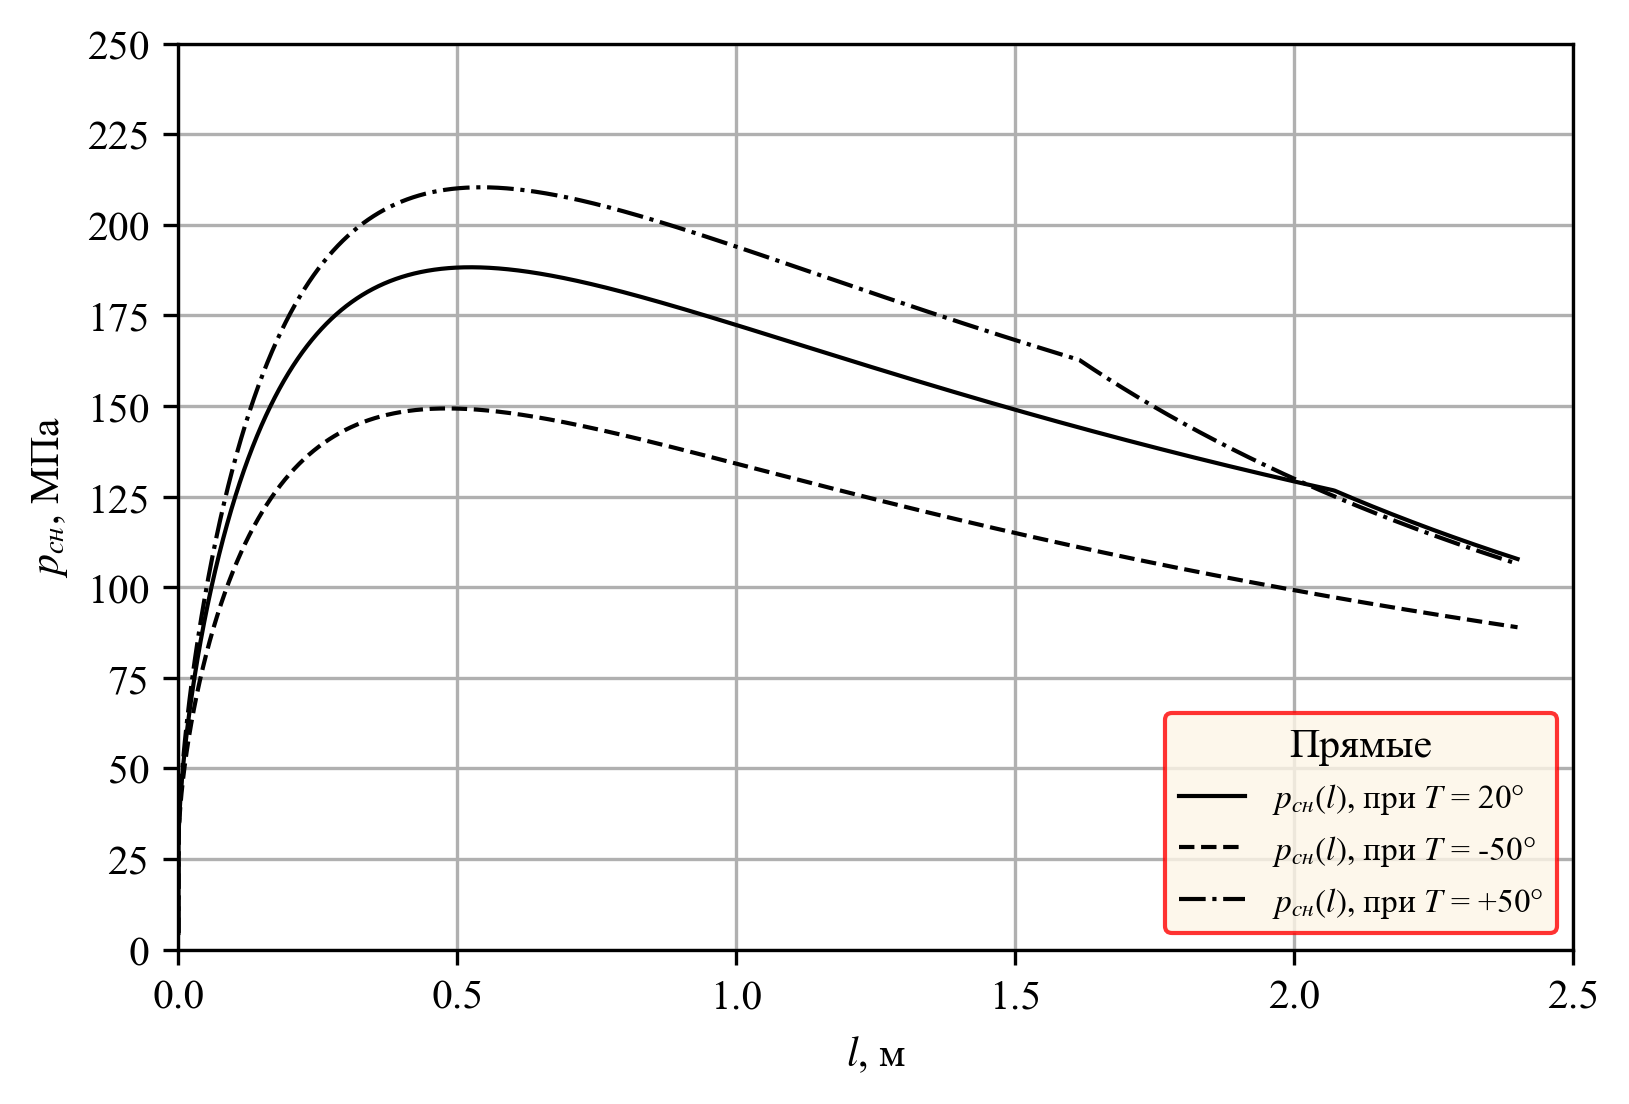

In [11]:
fig = plt.figure(dpi = 300)
host = fig.add_subplot(111)

host.set_xlim(0, 2.5)

plim = (0, 250)
host.set_ylim(*plim)

n=11
host.yaxis.set_ticks(np.linspace(*plim, n))

host.set_xlabel("$l$, м", fontsize=10)
host.set_ylabel("$p_{сн}$, МПа", fontsize=10)

color3 = 'black'

linestyle2 = '--'
linestyle3 = '-.'

p1, = host.plot(solve1['x_p'], pсн1, linewidth=1, color=color3, label='$p_{сн}(l)$, при $T$ = 20°')
p2, = host.plot(solve2['x_p'], pсн2, linewidth=1, color=color3, linestyle = linestyle2, label='$p_{сн}(l)$, при $T$ = -50°')
p3, = host.plot(solve3['x_p'], pсн3, linewidth=1, color=color3, linestyle = linestyle3, label='$p_{сн}(l)$, при $T$ = +50°')

lns1 = [p1,p2,p3]

host.legend(handles=lns1,
            fontsize = 8,
            ncol = 1,
            facecolor = 'oldlace',
            loc=4,
            edgecolor = 'r',
            title = 'Прямые',
            title_fontsize = '10')

host.grid()
plt.savefig('ПСО1.png', dpi=600, bbox_inches='tight')
plt.show()

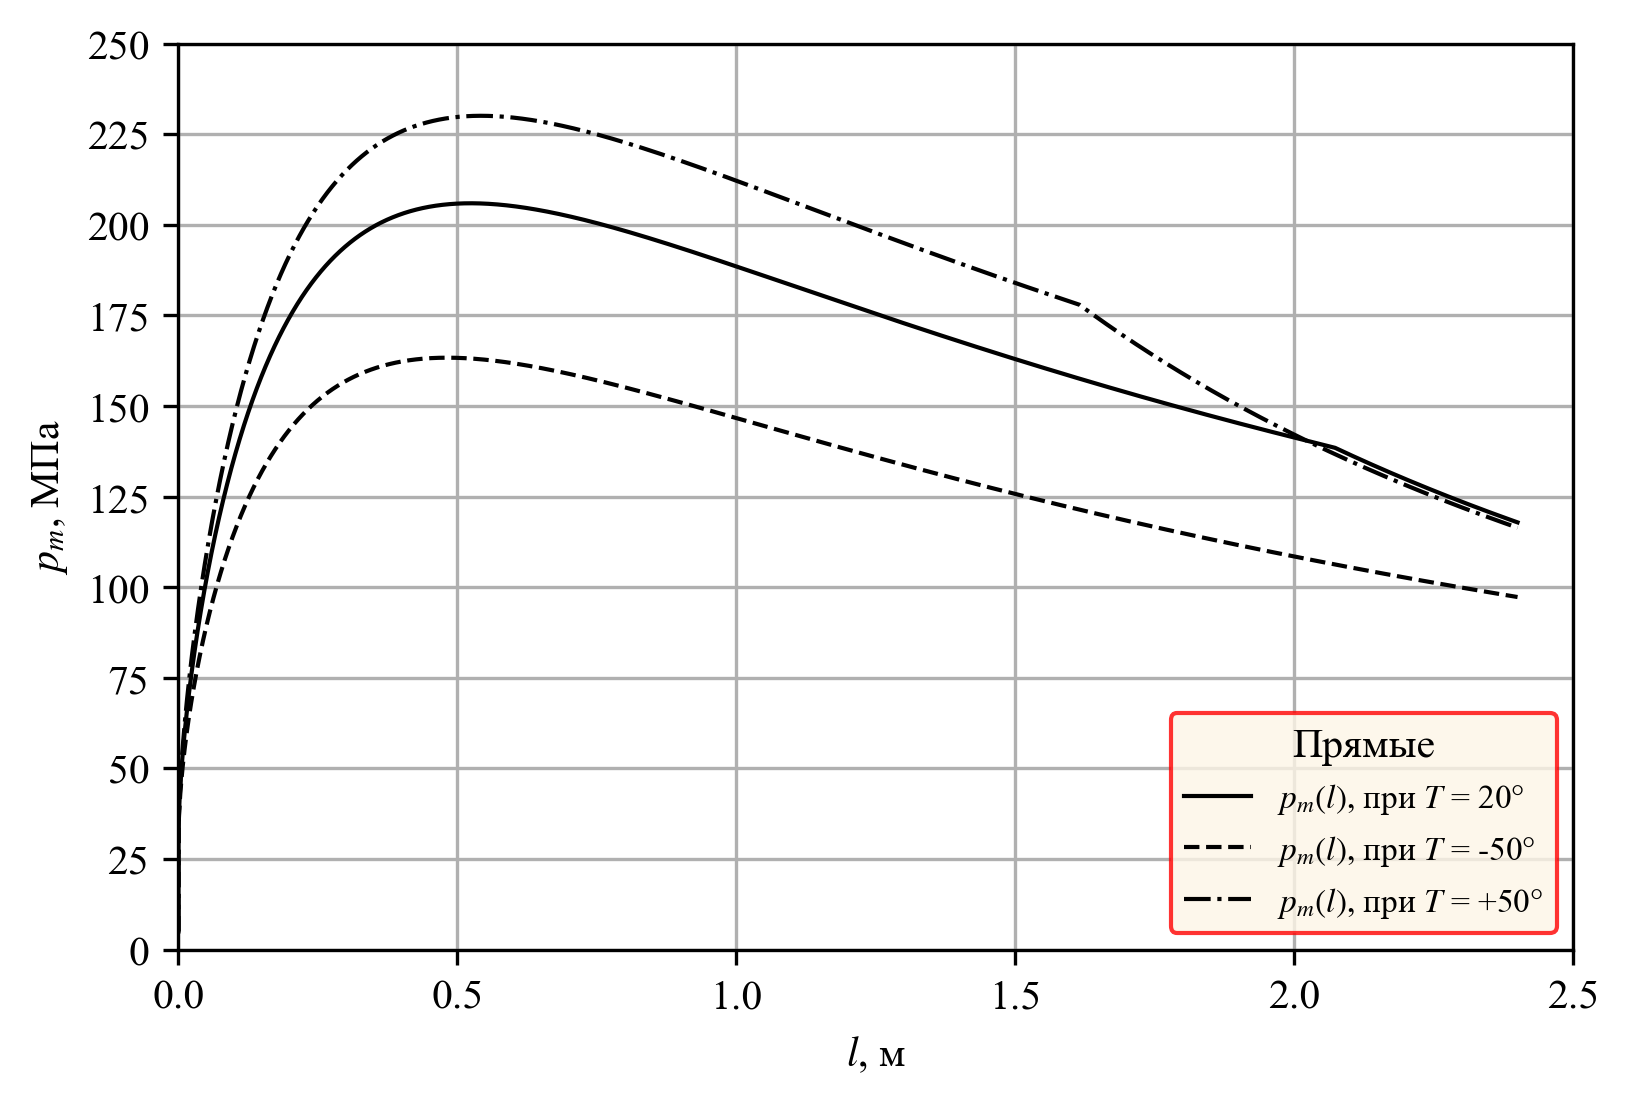

In [12]:
fig = plt.figure(dpi = 300)
host = fig.add_subplot(111)

host.set_xlim(0, 2.5)

plim = (0, 250)
host.set_ylim(*plim)

n=11
host.yaxis.set_ticks(np.linspace(*plim, n))

host.set_xlabel("$l$, м", fontsize=10)
host.set_ylabel("$p_m$, МПа", fontsize=10)

color3 = 'black'

linestyle2 = '--'
linestyle3 = '-.'

p1, = host.plot(solve1['x_p'], solve1['p_m']/1e6, linewidth=1, color=color3, label='$p_m(l)$, при $T$ = 20°')
p2, = host.plot(solve2['x_p'], solve2['p_m']/1e6, linewidth=1, color=color3, linestyle = linestyle2, label='$p_m(l)$, при $T$ = -50°')
p3, = host.plot(solve3['x_p'], solve3['p_m']/1e6, linewidth=1, color=color3, linestyle = linestyle3, label='$p_m(l)$, при $T$ = +50°')

lns1 = [p1,p2,p3]

host.legend(handles=lns1,
            fontsize = 8,
            ncol = 1,
            facecolor = 'oldlace',
            loc=4,
            edgecolor = 'r',
            title = 'Прямые',
            title_fontsize = '10')

host.grid()
plt.savefig('ПСО.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
k_air = 1.4
p0a = 1e5
c_0a = 340
ind_m = np.argmax(solve3['p_m'])
v_p = solve3['v_p'][ind_m]
mach = c_0a / v_p
mach_ = (k_air+1)*v_p/4/c_0a 
p0a *= 1 + k_air*(k_air+1)/4*(mach*mach) + k_air*mach*np.sqrt(1+mach_*mach_) 

In [ ]:
delta = get_db_powder(db_opt)['delta']
f_ign = get_db_powder('ДРП')['f']
b_ign = get_db_powder('ДРП')['b']
ω_ign = (p_ign  / f_ign) * (W_0 - (ω_opt / delta)) * (1 / (1 + b_ign * p_ign / f_ign))
φ = 1.02 + (ω_ign + ω_opt) / (3*q)
gx = S * ((solve3['p_m']) - 1e5) / (φ * q)
gx_max1 = S * (np.max(solve1['p_m']) - 1e5) / (φ * q)
gx_max2 = S * (np.max(solve2['p_m']) - 1e5) / (φ * q)
gx_max3 = S * (np.max(solve3['p_m']) - p0a) / (φ * q)
gx_max1/g, gx_max2, gx_max3/g

In [ ]:
solve1['v_p'][-1]

In [ ]:
# Дульная скорость
solve1['v_p'][-1], solve2['v_p'][-1], solve3['v_p'][-1]

In [ ]:
#Время начала движения снаряда:
flag = False
while flag == False:
    for i in range(len(solve3['t'])):
        if solve3['v_p'][i] > 0:
            ind03 = i-1
            flag = True
            break
flag = False
while flag == False:
    for i in range(len(solve1['t'])):
        if solve1['v_p'][i] > 0:
            ind01 = i-1
            flag = True
            break  
flag = False
while flag == False:
    for i in range(len(solve2['t'])):
        if solve2['v_p'][i] > 0:
            ind02 = i-1
            flag = True
            break 
solve1['t'][ind01], solve2['t'][ind02], solve3['t'][ind03] 

In [ ]:
# Дульное давление
solve1['p_m'][-1], solve2['p_m'][-1], solve3['p_m'][-1]

In [ ]:
#время достижения максимального среднебаллистического давления:
ind_max1 = np.argmax(solve1['p_m'])
ind_max2 = np.argmax(solve2['p_m'])
ind_max3 = np.argmax(solve3['p_m'])


solve1['t'][ind_max1] ,solve1['p_m'][ind_max1], solve2['t'][ind_max2] ,solve2['p_m'][ind_max2], solve3['t'][ind_max3] ,solve3['p_m'][ind_max3]

In [ ]:
# время вылета снаряда:
solve1['t'][-1], solve2['t'][-1], solve3['t'][-1]

In [ ]:
# время распада пороха
flag = False
while flag == False:
    for i in range(len(solve3['t'])):
        if solve3['z_1'][i] > 1:
            ind0 = i-1
            flag = True
            break
solve3['t'][ind0] , ind0

In [ ]:
t3r = 0.008914999999999722
t1r = 0.010034999999999676
p1r = solve1['p_m'][2007]
p3r = solve3['p_m'][1783]

In [ ]:
# время сгорания пороха
flag = False
while flag == False:
    for i in range(len(solve3['t'])):
        if solve3['psi_1'][i] == 1.0:
            ind0 = i-1
            flag = True
            break
solve3['t'][ind0], solve3['x_p'][ind0]

In [ ]:
fig = plt.figure(dpi = 300)
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

host.set_xlim(0, 12)

plim = (0, 250)
vlim = (0, 800)
xlim = (0, 10)
gxlim = (0,140000)

host.set_ylim(*plim)
par1.set_ylim(*vlim)
par2.set_ylim(*xlim)
par3.set_ylim(*gxlim)

n=11
host.yaxis.set_ticks(np.linspace(*plim, n))
par1.yaxis.set_ticks(np.linspace(*vlim, n))
par2.yaxis.set_ticks(np.linspace(*xlim, n))
par3.yaxis.set_ticks(np.linspace(*gxlim, n))

host.set_xlabel("$t$, мс", fontsize=10)
host.set_ylabel("$p_m$, МПа", fontsize=10)
par1.set_ylabel("$\\upsilon_p$, м/с", fontsize=10)
par2.set_ylabel("$x_p$, м", fontsize=10)
par3.set_ylabel("$g_x$, м/с$^2$", fontsize=10)

color1 = 'darkorange'
color2 = 'darkgreen'
color3 = 'black'
color4 = 'blue'
color5 = 'red'

linestyle2 = '--'
linestyle3 = '-.'

p1, = host.plot(solve1['t']*1e3, solve1['p_m']/1e6, linewidth=1, color=color5, label='$p_m(t)$, при $T$ = 20°')
p2, = par1.plot(solve1['t']*1e3, solve1['v_p'], linewidth=1,color=color2, label='$\\upsilon_p(t)$, при $T$ = 20°')
p3, = par2.plot(solve1['t']*1e3, solve1['x_p'], linewidth=1,color=color3, label='$x_p(t)$, при $T$ = 20°')
p4, = host.plot(solve2['t']*1e3, solve2['p_m']/1e6, linewidth=1,color=color5, linestyle = linestyle2, label='$p_m(t)$, при $T$ = -50°')
p5, = par1.plot(solve2['t']*1e3, solve2['v_p'], linewidth=1,color=color2, linestyle = linestyle2, label='$\\upsilon_p(t)$, при $T$ = -50°')
p6, = par2.plot(solve2['t']*1e3, solve2['x_p'], linewidth=1,color=color3, linestyle = linestyle2, label='$x_p(t)$, при $T$ = -50°')
p7, = host.plot(solve3['t']*1e3, solve3['p_m']/1e6, linewidth=1,color=color5, linestyle = linestyle3, label='$p_m(t)$, при $T$ = +50°')
p8, = par1.plot(solve3['t']*1e3, solve3['v_p'], linewidth=1,color=color2, linestyle = linestyle3, label='$\\upsilon_p(t)$, при $T$ = +50°')
p9, = par2.plot(solve3['t']*1e3, solve3['x_p'], linewidth=1,color=color3, linestyle = linestyle3, label='$x_p(t)$, при $T$ = +50°')
p10, = par3.plot(solve3['t']*1e3, gx, linewidth=1,color=color1, linestyle = linestyle3, label='$g_x(t)$, при $T$ = +50°')
p11, = host.plot(t1r*1e3, p1r/1e6,linewidth=10,marker='^',label='Сгорание (распад зерна) пороха при $T$ = 20°')
p12, = host.plot(t3r*1e3, p3r/1e6,linewidth=10,marker='s',label='Сгорание (распад зерна) пороха при $T$ = +50°')

lns1 = [p1,p4,p7,p2,p5,p8,p3,p5,p9,p10]

#host.legend(handles=lns, loc='upper left', fontsize=8)
host.legend(handles=lns1,
            fontsize = 8,
            ncol = 1,
            facecolor = 'oldlace',
            loc='upper left',
            edgecolor = 'r',
            title = 'Прямые',
            title_fontsize = '10'
         )
#lns2 = [p11,p12]

#par1.legend(handles=lns2, loc='best')
par2.spines['right'].set_position(('outward', 60))
par3.spines['right'].set_position(('outward', 120))   

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(color2)
par2.yaxis.label.set_color(color3)
par3.yaxis.label.set_color(color1)

host.grid()
plt.savefig('озвб.png', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
pmax20 = np.max(solve1['p_m'])
pmax50 = np.max(solve2['p_m'])
pmax_50 = np.max(solve3['p_m'])
pmm = solve1['p_m'][-1]
print(f'Коэффициент массы заряда = {ωq_opt}')
print(f'Плотность заряжания кг/м^3 = {Δ_opt} ')
print(f'Общий объем = {W_opt*1000} дм^3 ')
print(f'Объем каморы = {W_0*1000} дм^3')
print(f'Марка пороха {db_opt}')
print(f'Масса пороха =  {ω_opt} кг')
print('Дульная скорость при температуре 20° = ',solve1['v_p'][-1], 'м/с')
print('Дульная скорость при температуре +50° = ',solve3['v_p'][-1], 'м/с')
print('Дульная скорость при температуре -50° = ',solve2['v_p'][-1], 'м/с')
print(f'Дульное среднебаллистическое давление выстрела при +20° = {pmm}')
print(f'Максимальное среднебаллистическое давление выстрела при +20° = {pmax20}')
print(f'Максимальное среднебаллистическое давление выстрела при +50° = {pmax50}')
print(f'Максимальное среднебаллистическое давление выстрела при -50° = {pmax_50}')
print('Максимально допустимая длина ствола', l_m_max, 'м')
print('Ведущая часть канала ствола', solve1['x_p'][-1], 'м')
print('Длина ствола в калибрах', solve1['x_p'][-1]/d)
print(f'Максимальное допустимое ускорение снаряда gx_max = {14000*g} м/с^2')
print(f'Максимальное ускорение снаряда gx_max = {np.max(gx)} м/с^2')
print(f'Максимальная осевая перегрузка снаряда при температуре +50° nx_max = {np.max(gx)/g}')

Коэффициент массы заряда = 0.287
Плотность заряжания кг/м^3 = 530.9 
Общий объем = 15.219895782310894 дм^3 
Объем каморы = 3.838199284234318 дм^3
Марка пороха 16/1 тр
Масса пороха =  2.0376999999999996 кг
Дульная скорость при температуре 20° =  690.0 м/с
Дульная скорость при температуре +50° =  721.5556838966459 м/с
Дульная скорость при температуре -50° =  612.1440543732148 м/с
Дульное среднебаллистическое давление выстрела при +20° = 117872644.7726354
Максимальное среднебаллистическое давление выстрела при +20° = 205922811.71250138
Максимальное среднебаллистическое давление выстрела при +50° = 163311873.56645885
Максимальное среднебаллистическое давление выстрела при -50° = 230063785.84673172
Максимально допустимая длина ствола 4.953 м
Ведущая часть канала ствола 2.399793304358346 м
Длина ствола в калибрах 31.493350450896926
Максимальное допустимое ускорение снаряда gx_max = 137293.1 м/с^2


NameError: name 'gx' is not defined

# РАСПРЕДЕЛЕНИЯ ПАРАМЕТРОВ НА МДБР ЛУЧШЕГО ПОРОХА:

In [ ]:
file_opt

In [ ]:
open_data = open_file(file_opt)

In [ ]:
mass_ωq = open_data[0]
mass_Δ = open_data[1]
mass_solve = open_data[2]
mass_W = open_data[3]
mass_ωq_t = []
mass_Δ_t = []
mass_W_t = []
for m in range(len(mass_ωq)):
    if mass_solve[m] == True:
        mass_ωq_t.append(mass_ωq[m])
        mass_Δ_t.append(mass_Δ[m])
        mass_W_t.append(mass_W[m])
    else:
        continue

In [ ]:
# функция расчёта прямой задачи ВБ для одной точки какого-то пороха при соблюдении всех ограничений одновременно
def func_solve3(ωq, Δ, powder_name):
    
    # исходные данные:
    d = 76.2e-3
    q = 7.1
    v_pm = 690
    n_S = 1.04
    p_0 = 30e6
    p_ign = 5e6
    φ1 = 1.02
    g = 9.80665
    dt = 5e-6
    S = n_S * np.pi * ((d**2) / 4)

    # общие ограничения:
    p_m_max = 360e6
    l_m_max = 65 * d

    # индивидуальные ограничения:
    v_pm_50_min = 610
    g_p_50_max = 14000 * g
    
    # расчёт:
    Label = False
    ω = ωq * q
    W_0 = ω / Δ
    initial_data = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 293.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'v_p': 690, 'x_p': l_m_max, 'p_max': p_m_max}}
    result = ozvb_termo(initial_data)
    if result['stop_reason'] == 'v_p':
        l = result['x_p'][-1]
        W = result['W_p'][-1]
        # Проверка ограничения при -50:
        initial_data_50 = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 223.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'x_p': l, 'p_max': p_m_max}}
        result_50 = ozvb_termo(initial_data_50)
        if (result_50['v_p'][-1] >= v_pm_50_min):
            # Проверка ограничения при +50:
            initial_data50 = {'powders':[{'omega': ω, 'dbname': powder_name}],
                    'init_conditions':{'q': q,
                                       'd': d,
                                       'W_0': W_0,
                                       'T_0': 323.15,
                                       'phi_1': φ1,
                                       'p_0': p_0,
                                       'n_S': n_S},
                    'igniter':{'p_ign_0': p_ign},
                    'meta_termo':{'dt': dt,'method': 'rk4'},
                    'stop_conditions':{'t_max': 0.1, 'x_p': l, 'p_max': p_m_max}}
            result50 = ozvb_termo(initial_data50)
            if (result50['stop_reason'] == 'x_p'):
                delta = get_db_powder(powder_name)['delta']
                f_ign = get_db_powder('ДРП')['f']
                b_ign = get_db_powder('ДРП')['b']
                ω_ign = (p_ign  / f_ign) * (W_0 - (ω / delta)) * (1 / (1 + b_ign * p_ign / f_ign))
                φ = φ1 + (ω_ign + ω) / (3*q)
                gx_max = S * (np.max(result50['p_m']) - 1e5) / (φ * q)
                if (gx_max <= g_p_50_max):
                    Label = True
    else:
        l = l_m_max
        W = W_0 + S*l
    solve = {'Label': Label, 'W': W, 'x_p': l, 'W0': W_0, 'p_max': np.max(result['p_m'])}  
    return solve

In [ ]:
grad1 = []
grad2 = []
grad3 = []
for i in tqdm(range(len(mass_ωq_t))):
    res = func_solve3(mass_ωq_t[i],mass_Δ_t[i],db_opt)
    x_pm = res['x_p']
    W0 = res['W0']
    p_m = res['p_max']
    grad1.append(x_pm/d)
    grad2.append(p_m)
    grad3.append(W0/(d**3))

In [ ]:
plt.figure(dpi=100)
plt.xlabel('ω/q', fontsize=12)
plt.ylabel('$Δ$, кг/м$^3$', fontsize=12)
cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=grad1, cmap='bwr', s=5)
plt.colorbar(cb).set_label("$x_{pm}$/$d$", fontsize=12)
plt.xlim(0.1,1)
plt.ylim(100,600)
plt.grid()
plt.savefig('МДБР по длине.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
grad_p = [i/1e6 for i in grad2]
plt.figure(dpi=100)
plt.xlabel('ω/q', fontsize=12)
plt.ylabel('$Δ$, кг/м$^3$', fontsize=12)
cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=grad_p, cmap='bwr_r', s=5)
plt.colorbar(cb).set_label('$p_{m}$, МПа', fontsize=12)
plt.scatter(ωq_opt, ωq_opt, color='r',s=50, marker='*')
plt.xlim(0.1,1)
plt.ylim(100,600)
plt.grid()
plt.savefig('МДБР по давлению.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(dpi=100)
plt.xlabel('ω/q', fontsize=12)
plt.ylabel('$Δ$, кг/м$^3$', fontsize=12)
cb = plt.scatter(mass_ωq_t, mass_Δ_t, c=grad3, cmap=newcmp, s=5)
plt.colorbar(cb).set_label("$W_{0}$/$d^{3}$", fontsize=12)
plt.scatter(ωq_opt, ωq_opt, color='r',s=50, marker='*')
plt.xlim(0.1,1)
plt.ylim(100,600)
plt.grid()
plt.savefig('МДБР по объёму каморы.png', dpi=300, bbox_inches='tight')
plt.show()